# Read in Data & Plot Results

<IPython.core.display.Javascript object>


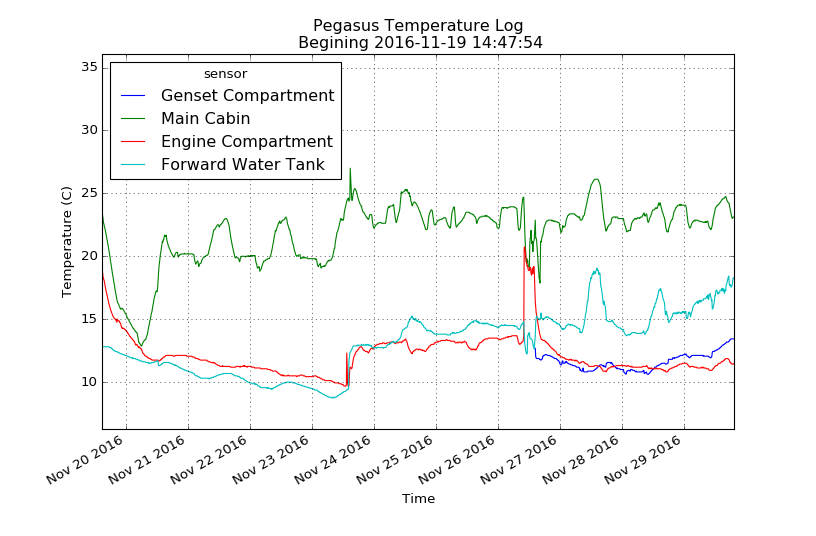

In [1]:
#Import Libraries
% matplotlib notebook
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import datetime
import requests

#---Data Source & Header info    
url = 'https://raw.githubusercontent.com/slawler/PegasusLogs/master/Temperature/Temperature.log'
cols = ['time','sensor', 'obs']    

df= pd.read_csv(url, header = None, sep = '\t' ,names = cols)

#Read & Format Data Table
def Observations_Table():
    df= pd.read_csv(url, header = None, sep = '\t' ,names = cols)
    df = df.pivot(index = 'time', columns='sensor', values='obs')
    df = df.set_index(pd.to_datetime(df.index,format = '%d.%Y.%m %H:%M:%S'))
    df.rename(columns ={3: 'Genset Compartment', 4: 'Main Cabin',
                        5: 'Engine Compartment',8:'Forward Water Tank'},inplace=True) 
    return df

#Plot Data
def Plot_Maker(df):
    import matplotlib.pyplot as plt
    fig = df.plot()
    plt.title('Pegasus Temperature Log'+ '\n Begining {}'.format(df.index[0]))
    plt.ylabel('Temperature (C)')
    plt.xlabel('Time')
    plt.grid(True)
    y_min = df.min().mean()*0.6
    y_max = df.max().mean()*1.8
    plt.ylim((y_min,y_max))
    
df = Observations_Table()
p = Plot_Maker(df)


# Add NOAA Station Temperature to Plot (Annaoplis, MD)

<IPython.core.display.Javascript object>


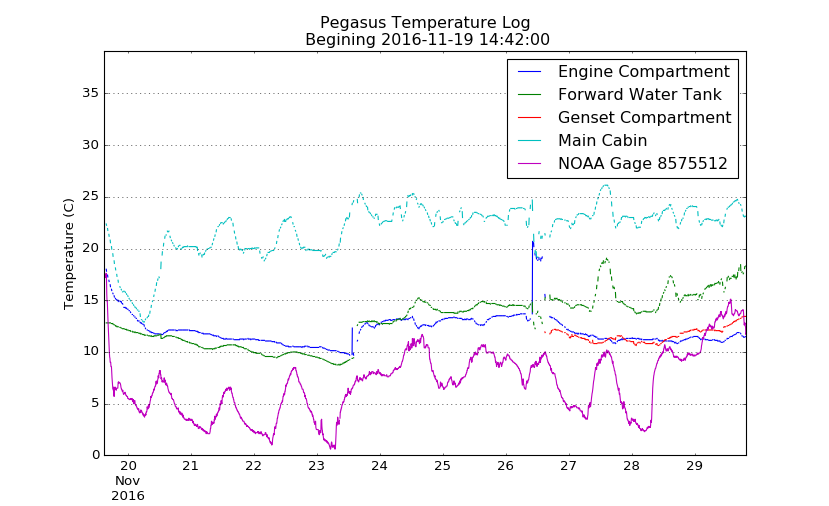

In [2]:
#--NOAA API https://tidesandcurrents.noaa.gov/api/
datum     = "msl"   #"NAVD"                  #Datum
units     = "metric"                         #Units
time_zone = "lst_ldt"                         #Time Zone
fmt       = "json"                            #Format
url       = 'http://tidesandcurrents.noaa.gov/api/datagetter'
product   = 'air_temperature'                     #Product
start = df.index[0]
stop  = df.index[-1]
noaa = pd.DataFrame()
g = 8575512 #Gage at Annapolis
freq = '6T'
t0     = start.strftime('%Y%m%d %H:%M')
t1     = stop.strftime('%Y%m%d %H:%M')

#---------------------Ping NOAA API for Validation Data,Create NOAA Dataframe
api_params = {'begin_date': t0, 'end_date': t1,
            'station': g,'product':product,'datum':datum,
            'units':units,'time_zone':time_zone,'format':fmt,
            'application':'web_services' }

pred=[];obsv=[];t=[]

try:
    r = requests.get(url, params = api_params)
    jdata =r.json()
    for j in jdata['data']:
        t.append(str(j['t']))
        obsv.append(str(j['v']))    
    noaa['time']= t
    noaa['NOAA Gage 8575512'] = pd.to_numeric(obsv)
except:
    print('NOAA Data unavailable')        
noaa = noaa.set_index(pd.to_datetime(noaa['time'],format = '%Y-%m-%d %H:%M'))


def Plot_Maker_w_Noaa(df,noaa):
    import matplotlib.pyplot as plt
    df2 = df.append(noaa)
    df2 = df2.resample('6T').mean()
    fig = df2.plot()
    y_min = 0
    y_max = df2.max().mean()*2.
    plt.ylim((y_min,y_max))
    
    plt.title('Pegasus Temperature Log'+ '\n Begining {}'.format(df2.index[0]))
    plt.ylabel('Temperature (C)')
    plt.xlabel('Time')
    plt.grid(True)
    return df2


p = Plot_Maker_w_Noaa(df,noaa)